In [2]:
import os
import sqlite3 as sql
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pytz import all_timezones

plt.style.use('fivethirtyeight')
#%matplotlib inline

In [164]:
#with sql.connect('../data/eng_tweets.db') as conn:
#    eng_tweets = pd.read_sql_query('select * from eng_tweets', conn)
eng_tweets = pd.read_pickle('../data/eng_tweets.p')
eng_tweets.head()

,external_author_id,author,content,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,hashtags,mentions
0,906000000000000000,10_GOP,We have a sitting Democrat US Senator on trial...,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,RightTroll,0,905874659358453760,914580356430536707,[],[@nedryun]
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti Trump s...,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,RightTroll,0,905874659358453760,914621840496189440,[],[]
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,1,RightTroll,0,905874659358453760,914623490375979008,[#BoycottNFL],[]
3,906000000000000000,10_GOP,JUST IN President Trump dedicates Presidents C...,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,RightTroll,0,905874659358453760,914639143690555392,[],[]
4,906000000000000000,10_GOP,19000 RESPECTING our National Anthem Stand For...,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,1,RightTroll,0,905874659358453760,914312219952861184,[#StandForOurAnthem],[]


In [165]:
eng_tweets['publish_date'] = pd.to_datetime(eng_tweets['publish_date'])

In [117]:
time_series = eng_tweets.groupby(eng_tweets.publish_date.dt.date)['author'].agg('count')
right_trolls = eng_tweets[eng_tweets.account_category=='RightTroll']
right_ts = right_trolls.groupby(right_trolls.publish_date.dt.date)['author'].agg('count')
left_trolls = eng_tweets[eng_tweets.account_category=='LeftTroll']
left_ts = left_trolls.groupby(left_trolls.publish_date.dt.date)['author'].agg('count')
fake_news = eng_tweets[eng_tweets.account_category=='Newsfeed']
news_ts = fake_news.groupby(fake_news.publish_date.dt.date)['author'].agg('count')

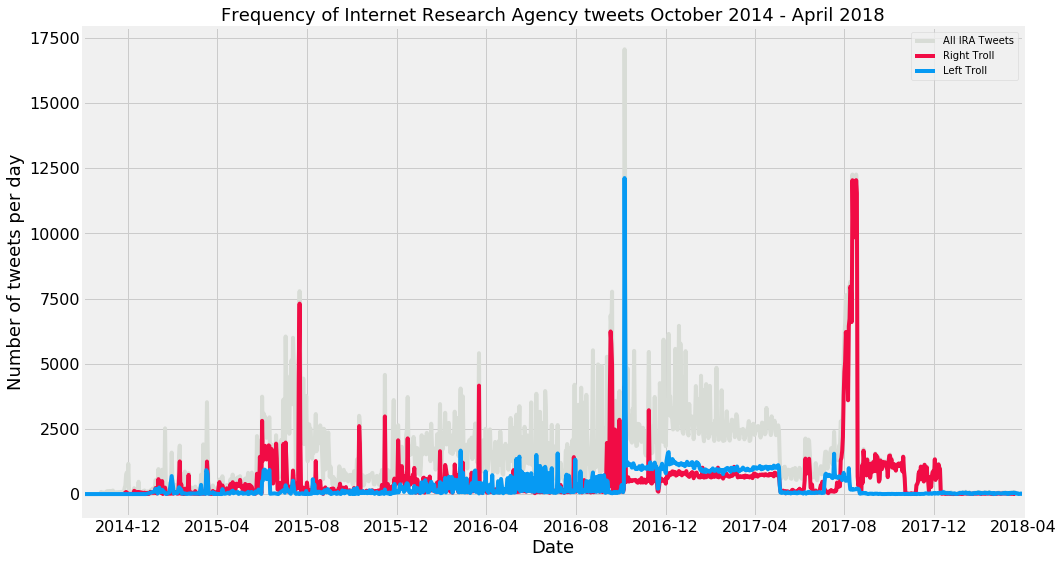

In [118]:
fig, ax = plt.subplots(figsize=(15,9))
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

ax.plot(time_series.index, time_series.values, '-', color='#d8dcd6', label='All IRA Tweets')
ax.plot(right_ts.index, right_ts.values,'-', color='#f10c45',label='Right Troll')
ax.plot(left_ts.index, left_ts.values,'-', color='#069af3', label='Left Troll')
#ax.plot(news_ts.index, news_ts.values, color='#929591', label='Newsfeed')

ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of tweets per day', fontsize=18)
ax.set_xlim(datetime.date(2014, 10, 1), datetime.date(2018, 4, 1))
ax.set_title('Frequency of Internet Research Agency tweets October 2014 - April 2018', fontsize=18)
ax.legend()

In [166]:
eng_tweets.publish_date.head()

0   2017-10-01 19:58:00
1   2017-10-01 22:43:00
2   2017-10-01 22:50:00
3   2017-10-01 23:52:00
4   2017-10-01 02:13:00
Name: publish_date, dtype: datetime64[ns]

In [167]:
eng_tweets.publish_date = eng_tweets.publish_date.dt.tz_localize('UTC') 
eng_tweets.publish_date = eng_tweets.publish_date.dt.tz_convert('Europe/Moscow')
eng_tweets['dayofweek'] = eng_tweets.publish_date.dt.day_name()
eng_tweets['timeofday'] = eng_tweets.publish_date
eng_tweets['date'] = eng_tweets.publish_date.dt.date
eng_tweets.publish_date.head()

0   2017-10-01 22:58:00+03:00
1   2017-10-02 01:43:00+03:00
2   2017-10-02 01:50:00+03:00
3   2017-10-02 02:52:00+03:00
4   2017-10-01 05:13:00+03:00
Name: publish_date, dtype: datetime64[ns, Europe/Moscow]

In [168]:
eng_tweets['dayofweek'].head()

0    Sunday
1    Monday
2    Monday
3    Monday
4    Sunday
Name: dayofweek, dtype: object

In [169]:
eng_tweets.author.value_counts()[0:10]

EXQUOTE            53158
SCREAMYMONKEY      43956
AMELIEBALDWIN      34308
SPECIALAFFAIR      32416
SEATTLE_POST       30680
KANSASDAILYNEWS    28746
ROOMOFRUMOR        28259
DAILYSANFRAN       27962
FINDDIET           25941
COVFEFENATIONUS    23463
Name: author, dtype: int64

In [170]:
#look at activity of a single account in the month of October--tweets per hour
user_name = 'AMELIEBALDWIN'
user = eng_tweets.loc[eng_tweets.author == user_name]
user = user[['author','publish_date','dayofweek','timeofday','date']]
startdate = datetime.datetime.strptime('2016-10-01', "%Y-%m-%d").date()
enddate = datetime.datetime.strptime('2016-10-31', "%Y-%m-%d").date()
mask = (user['date'] >= startdate) & (user['date'] <= enddate)
user = user.loc[mask]
user = user.set_index('publish_date')
user = (user.groupby(by=[amelie.index.day.rename('day'), 
                             user.index.hour.rename('hour')], as_index=False)
                            ['date','dayofweek','timeofday'].agg(list))
user.date = user.date.apply(lambda x: x[0])
user.dayofweek = user.dayofweek.apply(lambda x: x[0])
user['Tweets per hour'] = user.timeofday.apply(lambda x: len(x))
user.timeofday = user.timeofday.apply(lambda x: x[0])
user.timeofday = user.timeofday.dt.floor('1H').dt.hour
user.timeofday = user.timeofday.astype(str).apply(lambda x: x+":00:00")
#amelie = amelie.unstack('hour')
user.head()

AttributeError: 'RangeIndex' object has no attribute 'day'

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
y = [datetime.datetime.strptime(str(date),"%Y-%m-%d") for date in amelie.date]
x = [datetime.datetime.strptime(str(time),"%H:%M:%S").hour for time in amelie.timeofday]

ax.scatter(x, y, s=(amelie['Tweets per hour'].astype(float))) #, 
#            c = iris.petal_length, s=(iris.petal_width**2)*60, cmap="viridis")
ax.set_xlim(0,24)
ax.set_ylim(datetime.date(2016, 10, 1), datetime.date(2016, 10, 31))





#ax = plt.gca()

#plt.colorbar(label="petal_length")
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Date', fontsize=16)
plt.title('User '+user_name+' tweets per hour for the month of October 2016', fontsize=18)

#make a legend:
#pws = [0.5, 1, 1.5, 2., 2.5]
#for pw in pws:
#    plt.scatter([], [], s=(pw**2)*60, c="k",label=str(pw))

#h, l = plt.gca().get_legend_handles_labels()
#plt.legend(h[1:], l[1:], labelspacing=1.2, title="petal_width", borderpad=1, 
#            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")

#plt.show()